# [기상데이터 이용 태양광 발전량 예측](https://www.kaggle.com/c/2021-ml-p1)
> 기계학습 실습 9주차 - Decision Tree

In [404]:
!pip install kaggle

In [405]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        134           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        250           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        789           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       4255           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      34937            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       9202            True  
connectx

In [406]:
!kaggle competitions download -c 2021-ml-p1

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
data.csv: Skipping, found more recently modified local copy (use --force to force download)
X_test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [407]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

RANDOM_STATE = 42

In [408]:
train = pd.read_csv('data.csv')
X_test = pd.read_csv('X_test.csv')
submission = pd.read_csv('sample_submission.csv')

## Datasets
- Hour - 시간
- Minute - 분
- DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
- DNI - 직달일사량(Direct Normal Irradiance (W/m2))
- WS - 풍속(Wind Speed (m/s))
- RH - 상대습도(Relative Humidity (%))
- T - 기온(Temperature (Degree C))
- Target - 태양광 발전량 (kW)

In [409]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     9000 non-null   int64  
 1   Hour    9000 non-null   int64  
 2   Minute  9000 non-null   int64  
 3   DHI     9000 non-null   int64  
 4   DNI     9000 non-null   int64  
 5   WS      9000 non-null   float64
 6   RH      9000 non-null   float64
 7   T       9000 non-null   int64  
 8   TARGET  9000 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 632.9 KB


In [410]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,102,0,0,0,0,1.4,57.76,0,0.000000
1,99,15,0,222,18,1.3,26.82,13,21.957266
2,31,4,0,0,0,2.6,84.94,-6,0.000000
3,40,18,30,0,0,1.5,89.18,2,0.000000
4,191,1,30,0,0,2.4,84.35,12,0.000000


In [411]:
train.describe()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,103.671556,11.500444,14.983333,76.931778,208.159556,2.305856,64.191710,8.242444,18.174328
std,60.059711,6.931218,15.000824,119.150870,333.305000,1.259179,21.984384,9.553884,26.084176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,13.420000,-13.000000,0.000000
25%,52.000000,5.000000,0.000000,0.000000,0.000000,1.400000,48.137500,0.000000,0.000000
50%,103.000000,11.000000,0.000000,11.000000,0.000000,2.100000,66.495000,7.000000,1.032293
75%,155.000000,18.000000,30.000000,100.000000,355.000000,3.000000,80.680000,15.000000,31.810235
max,208.000000,23.000000,30.000000,528.000000,1059.000000,8.000000,100.000000,33.000000,97.849989


In [412]:
train['Day'].value_counts()

4      48
41     48
21     47
75     47
88     47
       ..
46     38
181    37
6      36
0      36
208    14
Name: Day, Length: 209, dtype: int64

In [413]:
train['Day'].unique()

array([102,  99,  31,  40, 191, 203, 152, 165,  62, 140,  10,  81,  63,
        24, 104,  19,  96, 111,  22, 141, 196,  34,   9, 184, 119, 131,
        51, 114,  44, 113, 112, 187,  83,  72, 181,  28, 139, 155, 207,
        39, 101,  98, 164,  37,  59, 129, 108,  46,  36,  21,  14,  89,
       116, 149, 170,  18,  64, 195,  12, 110, 158,  85, 127,   0,  78,
        77,   1, 192,  82, 120, 100,   6, 154,  60, 134,  52,  41, 202,
       200,  55, 186,  94,  45,  92,  80, 159, 151, 130, 117, 197,  26,
        65, 172,  66, 206,  57, 126,  84,  61, 136,  74, 160, 121, 178,
        76,  88,  71, 179, 161, 124,  27, 190, 148,   8, 150, 106, 173,
        56,  33, 193,  49, 107, 128, 171,  91, 205,  50, 168, 143,  16,
        47,  30,  23, 118, 103, 169, 180, 183,  15,   4,  13, 194, 157,
        95,  68, 201,   7, 166,  54, 176, 198,  87,  93,  79,  29, 175,
        86,  48, 135, 153, 177,  17, 167, 115, 163,  69, 144,  25,  32,
       132, 185, 147, 142,  75,  97, 145,  90, 189, 123,  42, 12

In [414]:
sorted(train['Hour'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [415]:
train['Minute'].unique()

array([ 0, 30])

## preprocessing

In [416]:
# Hour 과 Minute을 합쳐서 새로운 칼럼 만드는 것이 좋을 듯..
train['Time'] = train['Hour'] + train['Minute']/60
train['Time'].unique()

array([ 0. , 15. ,  4. , 18.5,  1.5,  0.5, 18. , 14.5, 20.5, 13. , 16.5,
       23. , 23.5, 20. ,  4.5,  2. , 10. ,  1. , 19.5, 21. ,  9. ,  3.5,
       10.5,  8. , 12.5, 19. , 11.5,  3. ,  7. ,  8.5,  6.5,  6. , 11. ,
       22. ,  2.5, 12. ,  5. , 16. , 22.5,  9.5, 13.5, 17. ,  7.5, 14. ,
        5.5, 15.5, 21.5, 17.5])

In [417]:
sorted(train['Time'].unique())

[0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5,
 20.0,
 20.5,
 21.0,
 21.5,
 22.0,
 22.5,
 23.0,
 23.5]

In [418]:
train.corr()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Time
Day,1.000000,-0.002970,-0.000428,0.227046,0.039446,-0.170277,-0.014705,0.759341,0.192415,-0.002984
Hour,-0.002970,1.000000,-0.005338,0.030302,-0.014034,-0.066130,-0.041723,0.106556,0.009202,0.999350
Minute,-0.000428,-0.005338,1.000000,-0.000989,-0.005900,-0.011299,0.013774,-0.010718,-0.003329,0.030718
DHI,0.227046,0.030302,-0.000989,1.000000,0.243508,0.151647,-0.506462,0.480056,0.681478,0.030252
DNI,0.039446,-0.014034,-0.005900,0.243508,1.000000,0.148420,-0.622468,0.411395,0.812898,-0.014241
WS,-0.170277,-0.066130,-0.011299,0.151647,0.148420,1.000000,-0.227789,-0.026184,0.164662,-0.066507
RH,-0.014705,-0.041723,0.013774,-0.506462,-0.622468,-0.227789,1.000000,-0.474163,-0.715153,-0.041207
T,0.759341,0.106556,-0.010718,0.480056,0.411395,-0.026184,-0.474163,1.000000,0.579782,0.106120
TARGET,0.192415,0.009202,-0.003329,0.681478,0.812898,0.164662,-0.715153,0.579782,1.000000,0.009078
Time,-0.002984,0.999350,0.030718,0.030252,-0.014241,-0.066507,-0.041207,0.106120,0.009078,1.000000


In [419]:
# 필요 없어 보이는 테이블 삭제
drop_cols = ['Hour', 'Minute', 'WS']

train.drop(drop_cols, axis=1, inplace=True)

In [420]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     9000 non-null   int64  
 1   DHI     9000 non-null   int64  
 2   DNI     9000 non-null   int64  
 3   RH      9000 non-null   float64
 4   T       9000 non-null   int64  
 5   TARGET  9000 non-null   float64
 6   Time    9000 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 492.3 KB


In [421]:
y_train = train['TARGET']
X_train = train.drop('TARGET', axis=1)

In [422]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)

X_train_mm = mm_scaler.transform(X_train)

## test data preprocessing

In [423]:
X_test['Time'] = X_test['Hour'] + X_test['Minute']/60
X_test.drop(drop_cols, axis=1, inplace=True)

X_test_mm = mm_scaler.transform(X_test)

## model validate

In [424]:
def validate(model, X, y, metric, params: dict = None) -> dict:
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, random_state=RANDOM_STATE)
  if params:
    model.set_params(**params)
  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  train_score = metric(y_train, y_train_pred)
  test_score = metric(y_test, y_test_pred)

  result = {'train': train_score, 'test': test_score, 'params': params}

  return result

In [425]:
params = None

validate(DecisionTreeRegressor(random_state=RANDOM_STATE),
         X_train, y_train, r2_score, params)

{'params': None, 'test': 0.9941094608498481, 'train': 0.9999999999963751}

### experiment
#### column drop에 따른 정확도
> 이 과정을 진행할 때 DecisionTree의 random_state값을 고정하지 않고 진행했다... 고정한 후에는 조금 다를 수 있다.

|dropped columns|score|
|---|---|
|None|0.9929549171519654|
|'Time'|0.9929582098988544|
|'Hour', 'Minute'| 0.9930072753966698|
|'Hour', 'Minute', 'Time'|0.9925980002147953|
|'Hour', 'Minute', 'Day'| 0.9918628464898318|
|*'Hour', 'Minute', 'WS'|0.9939508824710185|
|'Hour', 'Minute', 'WS', 'Day'|0.9924331990309031|

> \* : 정확도 가장 높음


In [426]:
# minmax scaling 한 것이 더 점수가 낮은 듯
validate(DecisionTreeRegressor(random_state=RANDOM_STATE),
         X_train_mm, y_train, r2_score, params)

{'params': None, 'test': 0.9940853665239199, 'train': 0.9999999999963751}

## parameter tuning 없이 제출해보기
> 0.99672

In [427]:
dt_reg = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt_reg.fit(X_train, y_train)

y_pred = dt_reg.predict(X_test)
submission['TARGET'] = y_pred
submission.to_csv('submission.csv', index=False)

In [428]:
## minmax scaling: 똑같이 0.99672 기록...
dt_reg_mm = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt_reg_mm.fit(X_train_mm, y_train)

y_pred = dt_reg_mm.predict(X_test_mm)
submission['TARGET'] = y_pred
submission.to_csv('submission_mm.csv', index=False)

### Decision Tree Visualization

[Text(448.60104225161564, 639.7753846153846, 'X[1] <= 56.5\nmse = 680.309\nsamples = 9000\nvalue = 18.174'),
 Text(121.95252166197324, 614.6861538461538, 'X[2] <= 548.5\nmse = 31.24\nsamples = 5469\nvalue = 1.708'),
 Text(52.18440019116542, 589.5969230769231, 'X[1] <= 20.5\nmse = 3.621\nsamples = 5205\nvalue = 0.634'),
 Text(9.99836444663238, 564.5076923076923, 'X[1] <= 9.5\nmse = 0.151\nsamples = 4672\nvalue = 0.086'),
 Text(2.4577994843958493, 539.4184615384615, 'X[1] <= 3.5\nmse = 0.008\nsamples = 4480\nvalue = 0.013'),
 Text(1.156611522068635, 514.3292307692308, 'X[1] <= 1.5\nmse = 0.0\nsamples = 4396\nvalue = 0.002'),
 Text(0.5783057610343175, 489.24, 'X[1] <= 0.5\nmse = 0.0\nsamples = 4367\nvalue = 0.0'),
 Text(0.28915288051715876, 464.15076923076924, 'mse = -0.0\nsamples = 4351\nvalue = 0.0'),
 Text(0.8674586415514762, 464.15076923076924, 'mse = 0.0\nsamples = 16\nvalue = 0.094'),
 Text(1.7349172831029525, 489.24, 'X[1] <= 2.5\nmse = 0.002\nsamples = 29\nvalue = 0.256'),
 Text(1

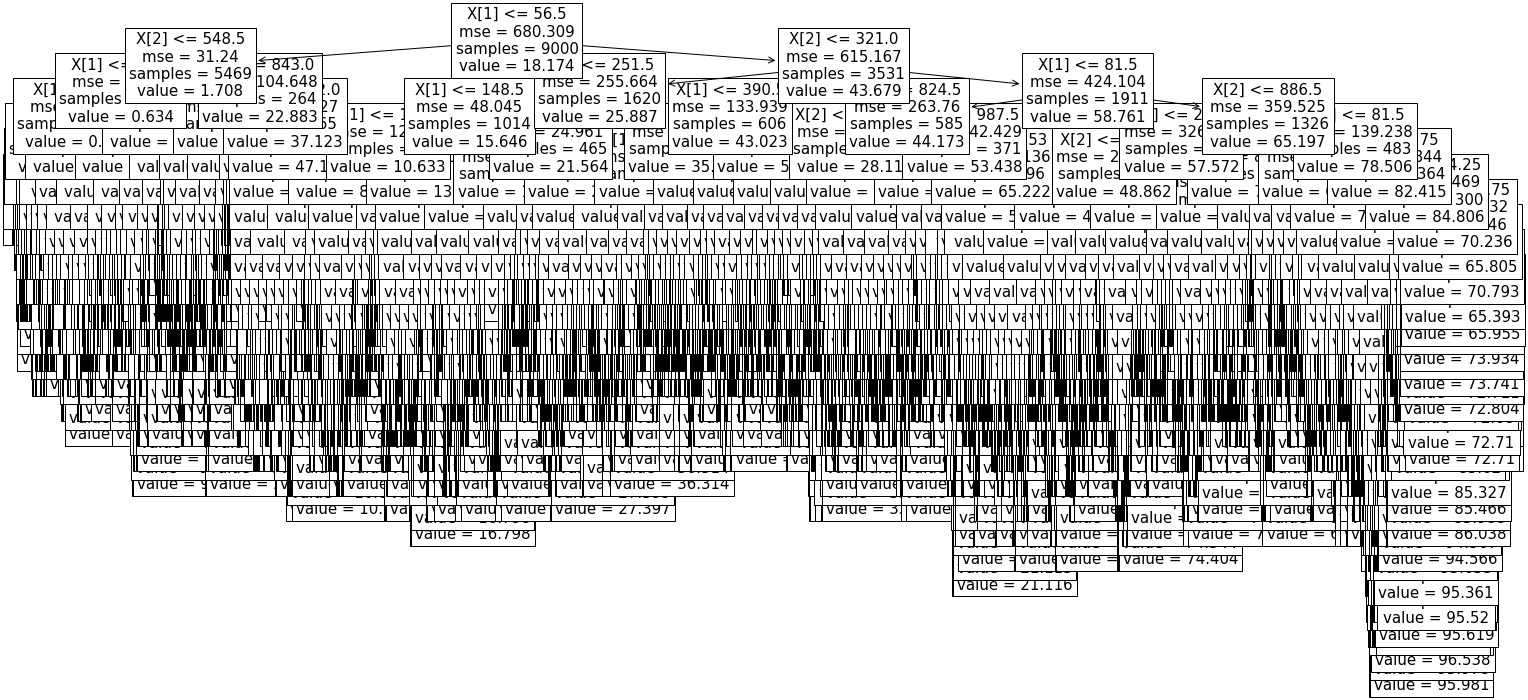

In [429]:
fig, ax = plt.subplots(figsize=(25, 12))
plot_tree(dt_reg, fontsize=15)

In [430]:
dt_reg.feature_importances_

array([0.00676592, 0.74208428, 0.24178962, 0.00147031, 0.00217076,
       0.0057191 ])

In [431]:
X_train.columns

Index(['Day', 'DHI', 'DNI', 'RH', 'T', 'Time'], dtype='object')

In [432]:
dt_reg.get_depth()

25

In [433]:
dt_reg.get_n_leaves()

3991

## parameter tuning

In [435]:
tuning_results = []

for min_samples_leaf_ in range(1, 10):
  for max_depth_ in range(10, 35 + 1):
    params = {'max_depth': max_depth_, 'min_samples_leaf': min_samples_leaf_}
    tuning_results.append(validate(DecisionTreeRegressor(random_state=RANDOM_STATE),
                                   X_train, y_train, r2_score, params))

In [436]:
sorted(tuning_results, key = lambda x: x['test'])

[{'params': {'max_depth': 10, 'min_samples_leaf': 9},
  'test': 0.9892365894096717,
  'train': 0.9934265967852285},
 {'params': {'max_depth': 11, 'min_samples_leaf': 9},
  'test': 0.9896069375293378,
  'train': 0.9943279817345472},
 {'params': {'max_depth': 10, 'min_samples_leaf': 8},
  'test': 0.989830947475097,
  'train': 0.9940267715633664},
 {'params': {'max_depth': 10, 'min_samples_leaf': 7},
  'test': 0.990153876861772,
  'train': 0.9944128418202164},
 {'params': {'max_depth': 11, 'min_samples_leaf': 8},
  'test': 0.990161372610769,
  'train': 0.9949971223804467},
 {'params': {'max_depth': 11, 'min_samples_leaf': 7},
  'test': 0.9905876105505911,
  'train': 0.995440871516933},
 {'params': {'max_depth': 12, 'min_samples_leaf': 9},
  'test': 0.9905887931705848,
  'train': 0.994784912987399},
 {'params': {'max_depth': 13, 'min_samples_leaf': 9},
  'test': 0.9907788105789278,
  'train': 0.9949010068174915},
 {'params': {'max_depth': 14, 'min_samples_leaf': 9},
  'test': 0.99078001786

minmax scaling한 데이터로도 학인해봤으나 안 한 것이 더 성능이 좋음...

In [445]:
tuning_results = []

for min_samples_split_ in range(2, 10):
  for min_samples_leaf_ in range(1, 10):
    for max_depth_ in range(10, 35 + 1):
      params = {'max_depth': max_depth_, 
                'min_samples_leaf': min_samples_leaf_,
                'min_samples_split': min_samples_split_}
      tuning_results.append(validate(DecisionTreeRegressor(random_state=RANDOM_STATE),
                                    X_train_mm, y_train, r2_score, params))

In [447]:
sorted(tuning_results, key = lambda x: x['test'], reverse=True)[:10]

[{'params': {'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 2},
  'test': 0.9942962773032095,
  'train': 0.9999998794715654},
 {'params': {'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 2},
  'test': 0.9942390470610095,
  'train': 0.9999990529270714},
 {'params': {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5},
  'test': 0.994218557963189,
  'train': 0.9992944068199466},
 {'params': {'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 5},
  'test': 0.994218557963189,
  'train': 0.9992944068199466},
 {'params': {'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 5},
  'test': 0.994218557963189,
  'train': 0.9992944068199466},
 {'params': {'max_depth': 23, 'min_samples_leaf': 2, 'min_samples_split': 5},
  'test': 0.994218557963189,
  'train': 0.9992944068199466},
 {'params': {'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 5},
  'test': 0.994218557963189,
  'train': 0.9992944068199466},
 {'params': {'max_depth':

## 최종 제출데이터 생성

### `min_samples_split` default
|max_depth|min_samples_leaf|score|
|---|---|---|
|19|1|0.99668|
|17|1|0.99680|
|17|3|0.99627|
|15|2|0.99690|

|max_depth|min_samples_leaf|min_samples_split|score|
|---|---|---|---|
|20|2|5|0.99680|

In [451]:
final_model = DecisionTreeRegressor(max_depth=15,
                                    min_samples_leaf=2)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
submission['TARGET'] = y_pred
submission.to_csv('final_submission.csv', index=False)

### DecisionTree Visualization

[Text(491.2944335672, 631.9350000000001, 'X[1] <= 56.5\nmse = 680.309\nsamples = 9000\nvalue = 18.174'),
 Text(156.39385220692185, 591.1650000000001, 'X[2] <= 548.5\nmse = 31.24\nsamples = 5469\nvalue = 1.708'),
 Text(74.82001641427871, 550.395, 'X[1] <= 20.5\nmse = 3.621\nsamples = 5205\nvalue = 0.634'),
 Text(16.327211679625904, 509.625, 'X[1] <= 9.5\nmse = 0.151\nsamples = 4672\nvalue = 0.086'),
 Text(5.157957696699472, 468.855, 'X[1] <= 3.5\nmse = 0.008\nsamples = 4480\nvalue = 0.013'),
 Text(2.4272742102115163, 428.08500000000004, 'X[1] <= 1.5\nmse = 0.0\nsamples = 4396\nvalue = 0.002'),
 Text(1.2136371051057582, 387.31500000000005, 'X[1] <= 0.5\nmse = 0.0\nsamples = 4367\nvalue = 0.0'),
 Text(0.6068185525528791, 346.545, 'mse = -0.0\nsamples = 4351\nvalue = 0.0'),
 Text(1.8204556576586373, 346.545, 'mse = 0.0\nsamples = 16\nvalue = 0.094'),
 Text(3.6409113153172745, 387.31500000000005, 'X[1] <= 2.5\nmse = 0.002\nsamples = 29\nvalue = 0.256'),
 Text(3.0340927627643954, 346.545, 'm

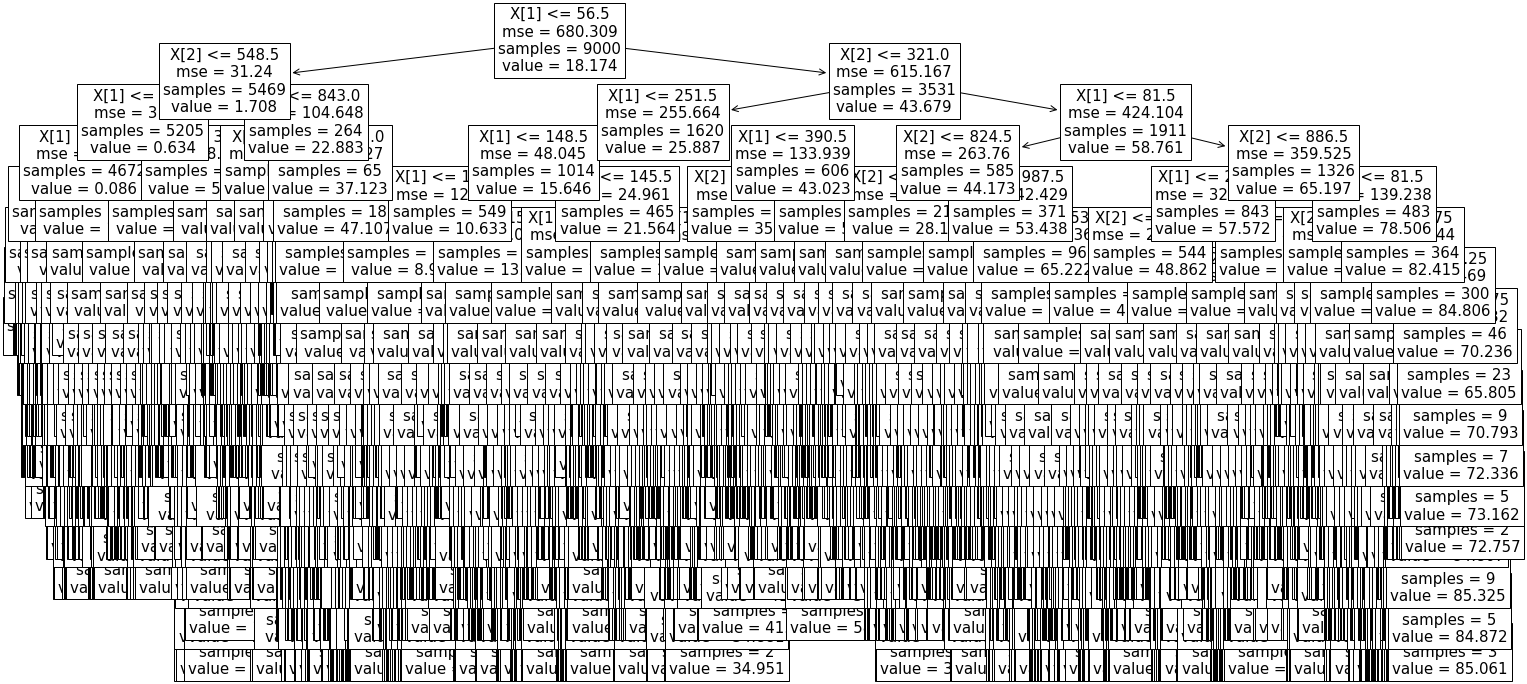

In [ ]:
fig, ax = plt.subplots(figsize=(25, 12))
plot_tree(final_model, fontsize=15)